#librerias

In [15]:
import nx

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import joblib
import os

#Dataset

In [4]:
# Read the dataset

df = pd.read_csv("Data/retencion-por-mes.csv")
df

,Cliente,Estado Cliente,Mes Registro,Mes de Abandono (Churn),1/2019,2/2019,3/2019,4/2019,5/2019,6/2019,...,3/2020,4/2020,5/2020,6/2020,7/2020,8/2020,9/2020,10/2020,11/2020,12/2020
0,George Garcia,Active,1/2019,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,James Johnson,Churned,1/2019,3/2019,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,John Williams,Churned,1/2019,8/2019,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Robert Jones,Active,1/2019,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Michael Brown,Active,1/2019,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Caroline Lyons,Active,12/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
326,Jesus Ramsey,Active,12/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
327,Herbert Wolfe,Active,12/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
328,Ian Schneider,Active,12/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#Modelo y FastAPI

In [26]:
# 1. Preprocessing

y = df['Estado Cliente']
x = df.drop(['Cliente', 'Estado Cliente', 'Mes Registro', 'Mes de Abandono (Churn)'], axis=1)

imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

x = pd.DataFrame(x_imputed, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. Hyperparameter optimization

pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__C': [0.1, 0.5, 1.0, 10.0]
}

# 3. Training

accuracy_history = []
precision_history = []
recall_history = []

grid_search_logistic_regression = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
for i in range(10):
  grid_search_logistic_regression.fit(x_train, y_train)

# 4. Metrics
  y_predictions = grid_search_logistic_regression.predict(x_test)
  accuracy = accuracy_score(y_test, y_predictions)
  accuracy_history.append(accuracy)


In [27]:
# 5. Packaging y 6. Read

filename = 'Data/retencion-por-mes.pkl'
joblib.dump(grid_search_logistic_regression, filename)

model = joblib.load(filename)

#Reentrenamiento automatizado del modelo

In [31]:
file_path = "Data/retencion-por-mes.csv"

def add_new_data(file_path):
    new_data = input("Ingrese los nuevos datos en el siguiente formato (Cliente, Estado Cliente, Mes Registro, Mes de Abandono (Churn), 1/2019, 2/2019, ..., 12/2020): ")

    new_data_list = new_data.split(",")

    with open(file_path, "a") as f:
        f.write("\n" + ",".join(new_data_list))

add_new_data(file_path)

In [32]:
def retrain_model(new_data_file, model):
    new_data = pd.read_csv(new_data_file)

    X_new = new_data.drop(['Cliente', 'Estado Cliente', 'Mes Registry', 'Mes de Abandono (Churn)'], axis=1)
    y_new = new_data['Estado Cliente']

    model.fit(X_new, y_new)

    new_data_file_name = "nuevos_datos_del_mes.csv"
    if os.path.exists(new_data_file_name):
        # Si el archivo ya existe, añadir los nuevos datos al final
        existing_data = pd.read_csv(new_data_file_name)
        updated_data = pd.concat([existing_data, new_data], ignore_index=True)
        updated_data.to_csv(new_data_file_name, index=False)
    else:
        # Si el archivo no existe, guardar los nuevos datos directamente
        new_data.to_csv(new_data_file_name, index=False)

    return model

In [16]:
G = nx.DiGraph()

G.add_nodes_from(["Inicio", "nuevos datos", "Entrenar el modelo",
                  "Guardar nuevos datos", "ingresa nuevos datos",
                  "Agregar nuevos datos", "Fin"])

G.add_edges_from([("Inicio", "nuevos datos"),
                  ("nuevos datos", "Entrenar el modelo"),
                  ("Entrenar el modelo", "Guardar nuevos datos"),
                  ("Entrenar el modelo", "ingresa nuevos datos"),
                  ("ingresa nuevos datos", "Agregar nuevos datos"),
                  ("Agregar nuevos datos", "Fin"),
                  ("Guardar nuevos datos", "Fin")])

# Dibujamos el grafo
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="yellow", font_size=12, font_weight="bold", arrows=True)
plt.title("Flujo de ejecución del código")
plt.show()

AttributeError: module 'nx' has no attribute 'DiGraph'

#Monitoreo del modelo:

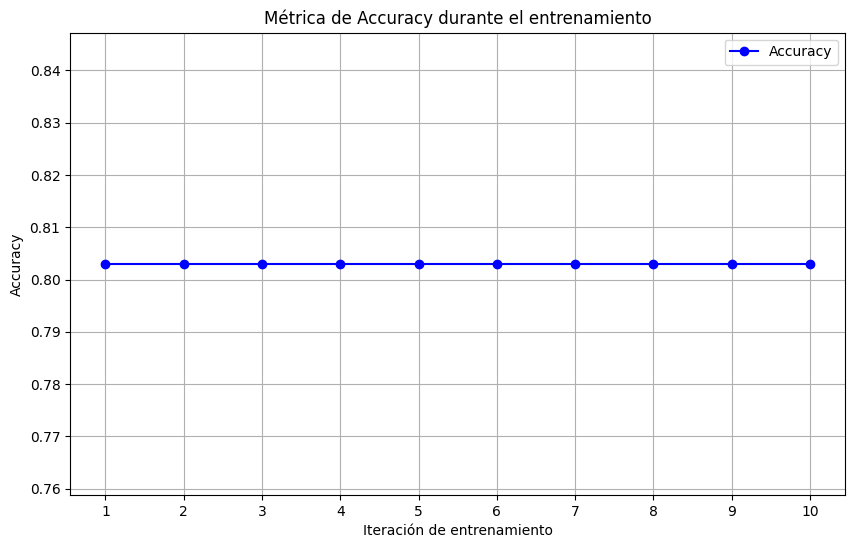

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracy_history, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Iteración de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Métrica de Accuracy durante el entrenamiento')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()